In [1]:
from segment_anything import SamPredictor, sam_model_registry
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
import pickle
import os.path as osp
import tqdm

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    
def getImage(image,resize=(256,256)):
    cmap = matplotlib.colormaps["viridis"]
    norm = plt.Normalize(image.min(), image.max())
    rgba_image = cmap(norm(image))
    rgb_image = np.array(rgba_image[:, :, :3])
    rgb_array_scaled = (rgb_image * 255).astype(np.uint8)
    if resize==-1:
        return rgb_array_scaled
    image_pil = Image.fromarray(rgb_array_scaled)
    new_size = resize
    resized_image_pil = image_pil.resize(new_size, Image.LANCZOS)
    return np.array(resized_image_pil)
def show(image):
    plt.figure()
    plt.axis("off")
    plt.imshow(image)
    plt.show()

def to_origin(mask,size=(401,31)):
    mask_img=Image.fromarray(mask)
    mask_img=mask_img.resize(size,Image.LANCZOS)
    mask_img=np.array(mask_img)
    return mask_img

def display_result(image, mask):
    plt.figure()
    plt.imshow(image)
    # show_box(input_box, plt.gca())
    show_mask(mask, plt.gca())
    # show_points(input_point, input_label, plt.gca())
    # plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    # plt.savefig(f"./outputs/res{i}.jpg")
    plt.show()

    

In [3]:
def S_inte(f, mask:np.ndarray, x_range=[0,2*np.pi],y_range=[-0.1,0.1]):
    y_len, x_len = mask.shape
    x_lis=np.linspace(x_range[0],x_range[1],x_len)
    y_lis=np.linspace(y_range[0],x_range[0],y_len)
    dx=(x_range[1]-x_range[0])/x_len
    dy=(y_range[1]-y_range[0])/y_len

    f_res=f(x_lis,y_lis)
    summ=0
    for y_ind in range(y_len):
        for x_ind in range(x_len):
            if mask[y_ind][x_ind]:
                summ+=f_res[y_ind][x_ind]*dx*dy
    return summ

def FL(f_trap,mask_origin, mgL):
    def numerator(x,y):
        return mgL*np.sin(x)*f_trap
    def denominator(x,y):
        return f_trap
    return S_inte(numerator,mask_origin)/S_inte(denominator,mask_origin)

In [4]:
sam = sam_model_registry["vit_h"](checkpoint="/home/wzy/segment-anything/checkpoints/sam_vit_h_4b8939.pth")
sam.to(device="cuda")
predictor = SamPredictor(sam)

mask_generator = SamAutomaticMaskGenerator(sam)

In [18]:
def get_mask(f_trap, predictor,thre=0.8,div=8,input_point=[[145,128]], show=False, save=False, save_dir=None):
    image=getImage(f_trap,(256,256))

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    predictor.set_image(image)
    input_point = np.array(input_point)
    input_label = np.array([1]) # 前景与背景
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=False,
    )
    # print(masks.shape) # (number_of_masks) x H x W
    mask=masks[0]
    score=scores[0]
    is_construct=True

    # print(np.sum(mask[:,-3:-1]) + np.sum(mask[:,0:2])+np.sum(mask[-3:-1,:])+np.sum(mask[0:2,:]))
    # print((mask.shape[0]+mask.shape[1])/8)
    if np.sum(mask[:,-3:-1]) + np.sum(mask[:,0:2])+np.sum(mask[-3:-1,:])+np.sum(mask[0:2,:])\
        >(mask.shape[0]+mask.shape[1])/div or score<thre:    
        is_construct=False
        # print("false")
    if show:
        plt.figure()
        plt.imshow(to_origin(f_trap,(256,256)))
        # show_box(input_box, plt.gca())
        show_mask(mask, plt.gca())
        show_points(input_point, input_label, plt.gca())
        plt.title(f"Mask {1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        # plt.savefig(f"./outputs/res{i}.jpg")
        plt.show()
    if save:
        plt.figure()
        plt.imshow(image)
        # show_box(input_box, plt.gca())
        show_mask(mask, plt.gca())
        show_points(input_point, input_label, plt.gca())
        plt.title(f"Mask {1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.savefig(save_dir)
        # plt.show()
    return to_origin(mask,size=f_trap.shape[::-1]), is_construct



def get_FL(f_trap, mask_origin, mgL):
    f_trap=np.transpose(f_trap)
    mask_origin=np.transpose(mask_origin)
    fl=FL(f_trap,mask_origin, mgL)
    # print(fl)
    return fl
def get_alpha(f_trap, mask_origin, mgL):
    f_trap=np.transpose(f_trap)
    mask_origin=np.transpose(mask_origin)
    fl=FL(f_trap,mask_origin, mgL)
    # print(fl)
    return fl/mgL


In [6]:
dist=np.load("/home/wzy/segment-anything/data/newd.npy")
print(dist.shape)

(10, 1001, 31, 401)


In [6]:
wb_lis=np.load("/home/wzy/segment-anything/data/wb2.npy")
print(wb_lis.shape)

(998, 1000)


In [7]:
k_lis=np.load("/home/wzy/segment-anything/data/kmode.npy")
print(k_lis.shape)

(1001,)


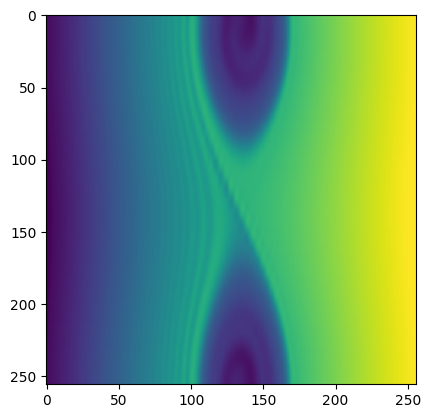

In [17]:
image=getImage(f_trap)
plt.imshow(image)
plt.show()

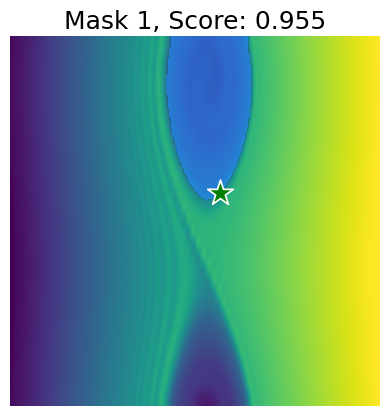

(array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 False)

In [23]:
f_trap=dist[8,640,:,:]
get_mask(f_trap,predictor,input_point=[[145,108]],show=True)

In [62]:
# res_dir="/home/wzy/segment-anything/outputs/mask_res"
# for time in [9]:
#     print(f"timestamp:{time}")
#     for space in tqdm.tqdm(range(830,860)):
#         f_trap=dist[time,space,:,:]
#         mask, is_construct= get_mask(f_trap,predictor,thre=0.6)
#         with open(osp.join("/home/wzy/segment-anything/outputs/mask_res",f"{time}_{space}_{is_construct}.pkl"),"wb") as fp:
#             pickle.dump((mask,is_construct),fp)
# if is_construct:
#     fl=get_FL(f_trap, mask, mgL=1)
#     print(fl)


timestamp:9


100%|██████████| 30/30 [00:33<00:00,  1.12s/it]


In [74]:
fl_lis=[]
res_dir="/home/wzy/segment-anything/outputs/mask_res"
for time in range(dist.shape[0]):
    print(f"timestamp:{time}")
    temp=[]
    for space in tqdm.tqdm(range(dist.shape[1]-1)):

        m=1
        real_time=time*100
        omega2=wb_lis[real_time][space]
        k2=k_lis[space]**2

        mgL=m*omega2/k2

        f_trap=dist[time,space,:,:]
        file_path=osp.join(res_dir,f"{time}_{space}_True.pkl")
        if osp.exists(file_path):
            with open(file_path,"rb") as fp:
                mask,is_construct=pickle.load(fp)
            fl=get_alpha(f_trap, mask, mgL=mgL)
            temp.append(fl)
        else:
            temp.append(None)
    fl_lis.append(temp)


timestamp:0


100%|██████████| 1000/1000 [00:00<00:00, 164915.82it/s]


timestamp:1


100%|██████████| 1000/1000 [00:00<00:00, 160541.38it/s]


timestamp:2


100%|██████████| 1000/1000 [00:00<00:00, 170944.90it/s]


timestamp:3


100%|██████████| 1000/1000 [00:00<00:00, 170078.42it/s]


timestamp:4


100%|██████████| 1000/1000 [00:00<00:00, 188626.73it/s]


timestamp:5


100%|██████████| 1000/1000 [00:00<00:00, 110898.81it/s]


timestamp:6


100%|██████████| 1000/1000 [00:00<00:00, 159740.41it/s]


timestamp:7


100%|██████████| 1000/1000 [00:00<00:00, 5266.13it/s]


timestamp:8


100%|██████████| 1000/1000 [00:00<00:00, 1749.66it/s]


timestamp:9


100%|██████████| 1000/1000 [00:00<00:00, 1550.45it/s]


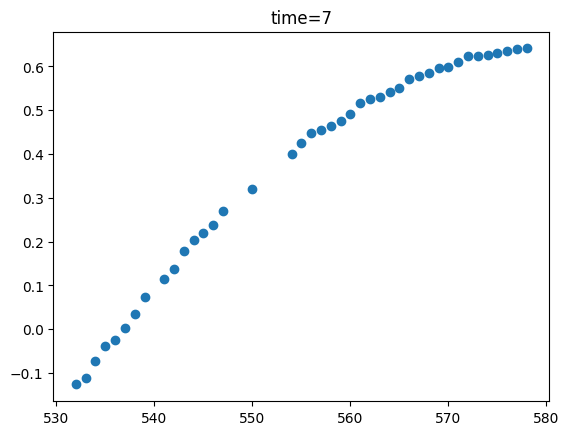

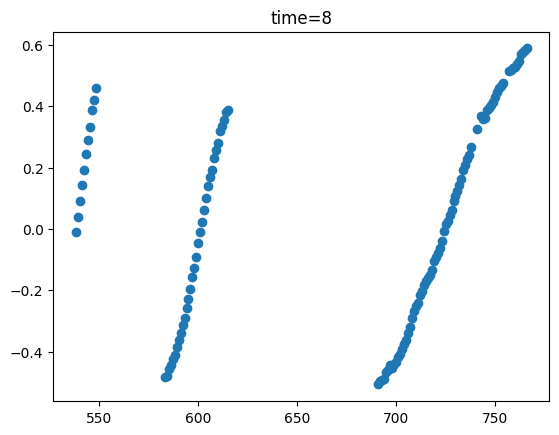

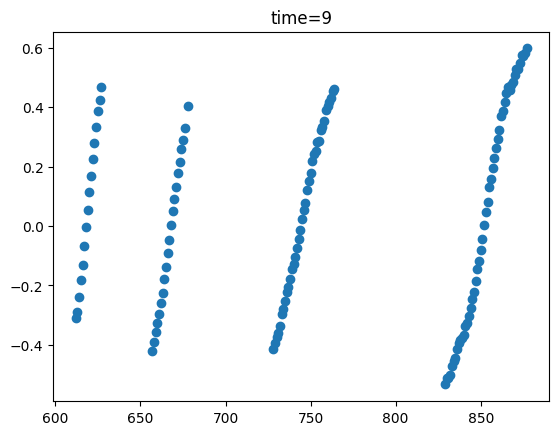

In [75]:

def scatter(x_lis, y_lis):
    x=[]
    y=[]
    for i in range(len(x_lis)):
        if y_lis[i] is not None:
            x.append(x_lis[i])
            y.append(y_lis[i])
    # print(y)
    plt.scatter(x,y)

space_lis=range(1000)
for time in [7,8,9]:
    plt.figure()
    scatter(space_lis,fl_lis[time])
    plt.title(f"time={time}")
    plt.show()

$$
H=\frac{1}{2} m L^2 \dot\theta^2 + mgL cos\theta + FL\theta
$$

$$
H=\frac{k^2}{2m}\Omega^2  + m \frac{\omega^2}{k^2} (cos\theta + \alpha \theta )
$$

$m=m_b$  
$gL=\frac{\omega^2}{k^2}$  
$L=\frac{k}{m}$  
$g=\frac{m\omega^2}{k^3}$  

$$
FL=\frac{\int\int_S dS mgL sin\theta f_{trap}}{\int\int_S dS f_{trap}}=mgL \alpha 
$$

100%|██████████| 130/130 [03:38<00:00,  1.68s/it]


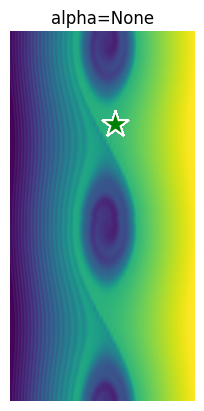

In [34]:
res_dir="/home/wzy/segment-anything/outputs/mask_res"
time=8
space=610
for space in tqdm.tqdm(range(670,800)):
    f_trap=dist[time,space,:,:]
    file_path=osp.join(res_dir,f"{time}_{space}_True.pkl")
    if osp.exists(file_path):
        with open(file_path,"rb") as fp:
            mask,is_construct=pickle.load(fp)
        mgL=wb_lis[time*10][space]/(k_lis[space]**2)
        fl=get_FL(f_trap, mask, mgL=mgL)
        alpha=fl/mgL
        # print(alpha)

        img=getImage(f_trap,resize=(256,256))
        mask_=to_origin(mask,(256,256))
        img=np.concatenate((img,img),axis=0)
        # mask_=np.concatenate((mask_,mask_),axis=0)
        plt.imshow(img)
        show_mask(mask_,plt.gca())
        show_points(np.array([[145,128]]),np.array([1]),plt.gca())
        plt.title(f"alpha={round(alpha,4)}")
        plt.axis("off")
        # plt.show()
    else:
        img=getImage(f_trap,resize=(256,256))
        img=np.concatenate((img,img),axis=0)
        plt.imshow(img)
        show_points(np.array([[145,128]]),np.array([1]),plt.gca())
        plt.title(f"alpha={None}")
        plt.axis("off")
    # plt.show()
    plt.savefig(f"/home/wzy/segment-anything/outputs/picts/{8}_{space}.jpg",bbox_inches='tight')


In [ ]:
f_trap=dist[8,620,:,:]
img=getImage(f_trap,resize=(256,256))
plt.imshow(img)